In [2]:
%matplotlib inline

# Esto me da un scoping para algunas celdas sin manchar el scope global. Hay
# que tener cuidado porque puede mutar cosas como un dataframe
%load_ext jupyter_spaces

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import time
import os
import shutil
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# Model evaluation
from sklearn.metrics import mean_squared_error

sns.set(color_codes=True)

import sys
sys.path.append('../src')
import reader


## Carga de datos

Se prueba primero con los datos del 2005

In [4]:
flights2005 = reader.read_flights(2005)

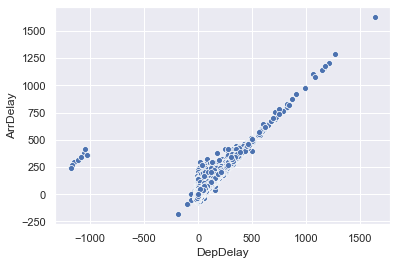

In [6]:
# Por el volumen de datos, ploteo solo un subsample del 5%
sns.scatterplot(x='DepDelay', y='ArrDelay', data=flights2005.sample(frac=.05))

## Filtrando outliers

Pueden verse outliers para numeros muy bajos de `DepDelay`.

### Método 1: Cuantiles

Empiezo por una función basada en cuantiles por columnas. Se queda solo con los elementos que estan dentro de determinado rango de cuantiles

In [18]:
def quantile_outlier_filter(data, frac):
    '''
    Un filtro de outliers basado en cuantiles. Remueve los datos que no se
    encuentran en el rango de los cuantiles `[frac, 1-frac]
    '''

    min_quantiles = data.quantile(frac)
    max_quantiles = data.quantile(1 - frac)
    return np.all((min_quantiles <= data) & (data <= max_quantiles), axis=1)

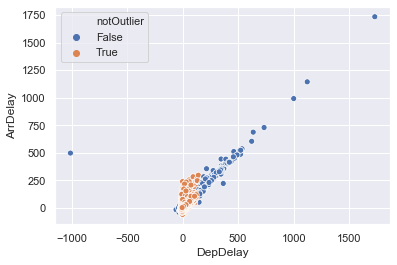

In [29]:
%%space trying_quantile_outlier_filter

flights = flights2005.loc[:, :]

frac = .01
flights['notOutlier'] = quantile_outlier_filter(flights[['DepDelay']], frac)

sns.scatterplot(x='DepDelay', y='ArrDelay', hue='notOutlier',
                data=flights.sample(frac=.01))
plt.plot()

Ok. no esta bueno este metodo. Parece que se pierden datos que siguen el patron
lineal.

Si vemos la distribución conjunta de las dos variables, da que tienen una
kurtosis altisima.

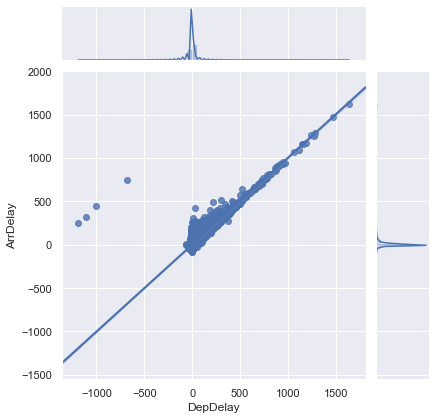

In [25]:
sns.jointplot("DepDelay", "ArrDelay",
              data=flights2005.sample(frac=.05),
              kind="reg")

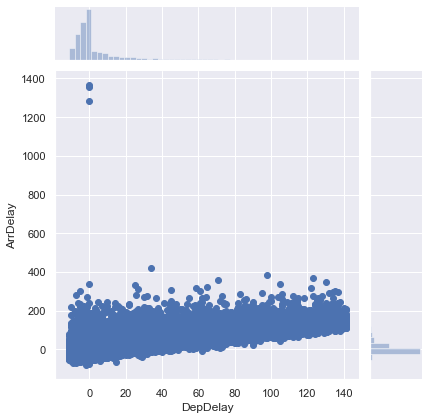

In [31]:
%%space trying_quantile_outlier_filter

flights = flights2005.loc[:, :]

frac = .01
flights['notOutlier'] = quantile_outlier_filter(flights[['DepDelay']], frac)

sns.jointplot(x='DepDelay', y='ArrDelay',
                data=flights[flights['notOutlier']].sample(frac=.1))

### Segundo método outliers:

Como segundo método, se filtran a mano los elementos dejando los vuelos cuya `DepDelay` sea mayor a $-100$.

In [33]:
def eyesight_outlier_filter(data):
    '''
    Deja pasar los vuelos cuyo `DepDelay` sea mayor a -100. Se llama asi porque lo elegí a ojo.
    '''
    return -100 < data['DepDelay']

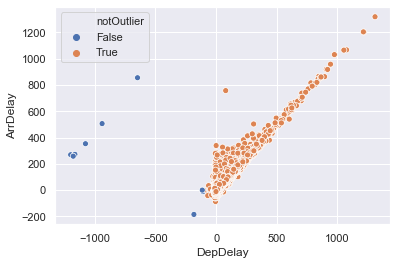

In [37]:
%%space trying_eyesight_outlier_filter

flights = flights2005.loc[:, :]
flights['notOutlier'] = eyesight_outlier_filter(flights)

sns.scatterplot(x='DepDelay', y='ArrDelay', hue='notOutlier',
                data=flights.sample(frac=.05))
plt.plot()

In [ ]:
def nrmse(y_true, y_pred):
    '''
    Devuelve el _Normalized Root Mean Square Error_ (NRMSE) entre `y_true` y
    `y_pred`.
    '''
    
    y_min = y_true.min()
    y_max = y_true.max()
    y_span = y_max - y_min
    
    mse = mean_squared_error(y_true, y_pred)
    
    return np.sqrt( mse / y_span**2 )

In [54]:
flights = flights2005.copy(deep=False)
flights = flights.loc[:, ['DepDelay', 'ArrDelay']]
flights = flights.dropna()
flights = flights[eyesight_outlier_filter(flights)]

X = flights[['DepDelay']]
y_true = flights['ArrDelay']

lm = LinearRegression()
lm.fit(X, y_true)
y_pred = lm.predict(X)


[]

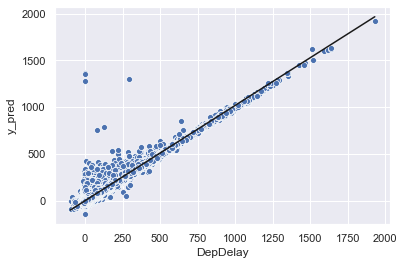

In [55]:
# Plot de la regresión
flights['y_pred'] = y_pred
sns.scatterplot('DepDelay', 'ArrDelay', data=flights.sample(frac=0.5))
sns.lineplot('DepDelay', 'y_pred', data=flights.sample(frac=0.5), color='k')
plt.plot()


In [65]:
def overlay_model_on_relational_plot(model, ax=None, xmin=None, xmax=None):
    '''
    Dibuja la regresión lineal arriba de un plot relacional (i.e. scaterplot).
    '''

    # Obtiene rango [xmin, xmax] para hacer el plot

    if xmin is None:
        if ax is None:
            raise ValueError('xmin is None and could not be infered from ax.')
        xmin = ax.get_xlim()[0]

    if xmax is None:
        if ax is None:
            raise ValueError('xmax is None and could not be infered from ax.')
        xmax = ax.get_xlim()[1]
    
    if ax is None:
        ax = plt.gca()
    
    xs = np.arange(xmin, xmax, 10).reshape(-1, 1)
    ys = lm.predict(xs)
    ax.plot(xs, ys)

Se puede ver que existe bias a sobreestimar el tiempo de demora de arribo en la parte superior. Puede tener que ver con los outliers en los valores mas bajos de 

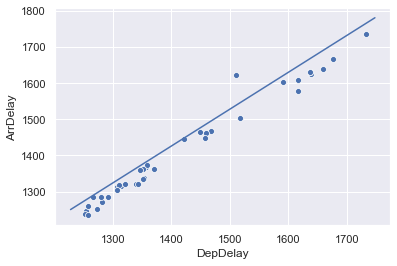

In [68]:
%%space detail

flights_subset = flights2005.copy(deep=False)
flights_subset = flights_subset[(1250 < flights_subset['DepDelay']) & (flights_subset['DepDelay'] < 1750)]
# Plot de la regresión
ax = sns.scatterplot('DepDelay', 'ArrDelay', data=flights_subset)
overlay_model_on_relational_plot(lm, ax=ax)
plt.plot()

Viendo en detalle la parte con la mayor densidad de observaciones, hay bias y heterocedasticidad

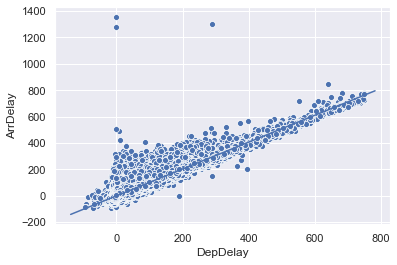

In [70]:
%%space detail

flights_subset = flights2005.copy(deep=False)
flights_subset = flights_subset[(-100 < flights_subset['DepDelay']) & (flights_subset['DepDelay'] < 750)]
flights_subset = flights_subset.sample(frac=.5)
# Plot de la regresión
ax = sns.scatterplot('DepDelay', 'ArrDelay', data=flights_subset)
overlay_model_on_relational_plot(lm, ax=ax)
plt.plot()

Se nota que existe una correlación lineal, pero me gustaría meterle mas variables al modelo

[]

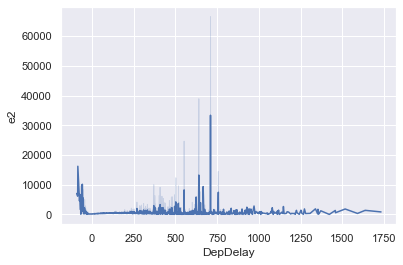

In [72]:
flights['e2'] = ( y_true - y_pred ) ** 2
sns.lineplot('DepDelay', 'e2', data=flights.sample(frac=0.5))
plt.plot()

In [57]:
nrmse(y_true, y_pred)

0.00645557352325263

(-175.93267605278808, 1796.4914676191588)

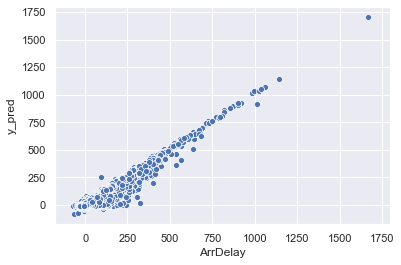

In [80]:
sns.scatterplot('ArrDelay', 'y_pred', data=flights.sample(frac=.05))

# Pongo ambos ejes en la misma escala
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
lim = (min([xmin, ymin]), max([xmax, ymax]))
plt.xlim(lim)
plt.ylim(lim)

In [85]:
flights.loc[:, ['DepDelay', 'ArrDelay']].corr()

,DepDelay,ArrDelay
DepDelay,1.000000,0.920106
ArrDelay,0.920106,1.000000


$\rho = 0.92$